# Environment Setting

In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 14.6 MB/s 
     |████████████████████████████████| 51 kB 3.3 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=5c44bd74d9a5788fd89b12de3d91d26fc2a4e89a3a05bff09e629d67450bcb1f
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
from glob import glob
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import joblib
import pretty_midi
import IPython
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        # plt.figure(figsize=(20, 15))
        plt.show()

# Drum Mapping

- Roland Mapping 기반 9차원 Mapping

In [ ]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Crash',
   'Ride' 
]

MIDI_DRUM_MAP = {
    36: 0,
    38: 1,
    40: 1,
    37: 1,
    48: 5,
    50: 6,
    45: 4,
    47: 5,
    43: 4,
    58: 4,
    46: 3,
    26: 3,
    42: 2,
    22: 2,
    44: 2,
    49: 7,
    55: 7,
    57: 7,
    52: 7,
    51: 8,
    59: 8,
    53: 8 
}

In [ ]:
MIN_NB_ONSETS = 1
nb_bars = 4
resolution = 4                      # separate quater into 4  = 16 notes per bar
len_seq = resolution * 4 * nb_bars  # length of drumloops in training data - 2 bars
nb_notes = len(DRUM_CLASSES)        # number of possible MIDI notes  - max_drum_note - min_drum_note

In [21]:
# Load Groove MIDI, 4/4 만 사용
filepaths = glob('/content/drive/MyDrive/Colab Notebooks/groove/*/*/*beat_4-4.mid')
print(len(filepaths))

491


# 장르 확인

In [22]:
# genres 
all_genres = {}
for path in filepaths:
    _path = os.path.basename(path)
    path = _path.split("_")[1]
    genre = path.split("-")[0]
    if genre not in all_genres:
        all_genres[genre] = 1
    else:
        all_genres[genre] += 1        
print (all_genres)

# genre used. ignore smaller genres
GENRES = []
for genre, nb in all_genres.items():
    if nb > 25:
        GENRES.append(genre)
print("Genres", GENRES)
NB_GENRES = len(GENRES)

{'rock': 204, 'highlife': 2, 'latin': 48, 'dance': 7, 'funk': 53, 'afrobeat': 13, 'neworleans': 13, 'hiphop': 34, 'soul': 28, 'pop': 15, 'jazz': 48, 'country': 2, 'reggae': 4, 'afrocuban': 7, 'middleeastern': 1, 'blues': 4, 'gospel': 1, 'punk': 7}
Genres ['rock', 'latin', 'funk', 'hiphop', 'soul', 'jazz']


# 9차원 드럼 midi를 piano roll에 대응시켜 행렬변환

In [10]:
# unit timestep = 16th note
def get_pianomatrices_of_drums(midi_file, is_drum=True):
    found = False
    genre_id = -1
    
    # select genres
    for id_, genre in enumerate(GENRES):
        if genre in midi_file:
            found = True
            genre_id = id_
            break
    if found is False:
        return (None, None, None, None)
    
    # load midi file
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
    except:
        print ("Failed to load midi: ", midi_file)
        return (None, None, None, None)
        
    # get timiming of quater notes
    beats = pm.get_beats()
    
    # make it to 16th notes
    beats_ticks = [] # converting to ticks
    
    for i in range((len(beats) +1)* 4):
        beats_ticks.append(i * pm.resolution / 4)
    
    num_notes16 = len(beats_ticks) 
    print(midi_file[-25:-4])
    
    # maximum duration of one note
    max_duration = 2.0 # 2 quater notes

    # convert ticks to index of 16th note
    def find_note_index(tick, beats_ticks):
        return (np.abs(beats_ticks - tick)).argmin()
    
    def get_timeshift(beats_ticks, grid_id, note_start):
        grid_start = beats_ticks[grid_id]
        tick_diff = note_start - grid_start
        tick_grid = pm.resolution / 4        
        diff_coef= tick_diff / tick_grid * 2.0
        return diff_coef
        
    # # of notes
    notes_length = 4 * nb_bars * resolution

    # create pianoroll matrix (resolution: 16th note))
    found_extra = False # with other than kick/snare/hat
    pianorolls, timeshifts, durations, genre_ids = [], [], [], []
    for instrument in pm.instruments:
        if instrument.is_drum == is_drum:  # use drum tracks only
            
            for note_start in range(0, num_notes16 - 64, 64): # hopsize = 1bar = 16 16th notes
                pianoroll = np.zeros((notes_length, nb_notes), dtype='float') 
                timeshift = np.zeros((notes_length, nb_notes), dtype='float')
                duration = np.zeros((notes_length, nb_notes), dtype='float')

                for note in instrument.notes:
                    idx_start = find_note_index(pm.time_to_tick(note.start), beats_ticks)
                    diff_coef = get_timeshift(beats_ticks, idx_start, pm.time_to_tick(note.start))

                    if note_start <= idx_start and idx_start < note_start + notes_length:
                        if note.pitch in MIDI_DRUM_MAP:
                            drum_note = MIDI_DRUM_MAP[note.pitch]
                            
                            pianoroll[idx_start - note_start, drum_note] = note.velocity / 128.
                            timeshift[idx_start - note_start, drum_note] = diff_coef

                            dur = (pm.time_to_tick(note.end) - pm.time_to_tick(note.start))/ (pm.resolution / 4)
                            dur = min(1.0, max(0, dur / max_duration))
                            duration[idx_start - note_start, drum_note] = dur

                            if drum_note >= 3:
                                found_extra = True
                        else:
                            print("not found", note.pitch )
                
                if np.sum(pianoroll > 0.) >= MIN_NB_ONSETS:
                    pianorolls.append(pianoroll)
                    timeshifts.append(timeshift)
                    durations.append(duration)
                    genre_ids.append(genre_id)
             
    # ignore the first and the last one!
    pianorolls = np.array(pianorolls)
    timeshifts = np.array(timeshifts)
    durations = np.array(durations)
    genre_ids = np.array(genre_ids)
    
    return (pianorolls,timeshifts, durations, genre_ids)

# 샘플 시각화
- 4/4: 한 마디 안에 4분음표 4개 = 16비트
- 첫 4마디 시각화 = 4 * 16 = 64비트

In [25]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [30]:
def viz_drum_midi(pth):
    (drums, timeshift, duration, genre_ids) = get_pianomatrices_of_drums(pth)
    plot_drum_matrix(drums[0])

    file_list = os.listdir('./')
    file_list_wav = [file for file in file_list if file.endswith(".wav")]
    
    for s in file_list_wav:
        if s.endswith(pth[-23:-4]+'.wav'):
            # print('play')
            IPython.display.Audio(s, autoplay=False)

groove10_102_beat_4-4


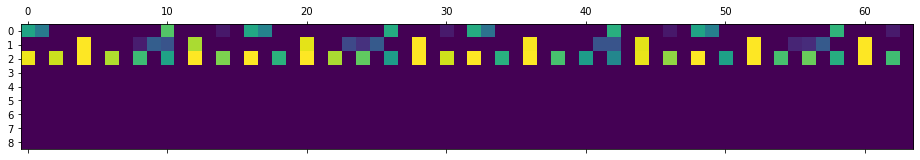

In [37]:
viz_drum_midi(filepaths[101])

7_hiphop_100_beat_4-4


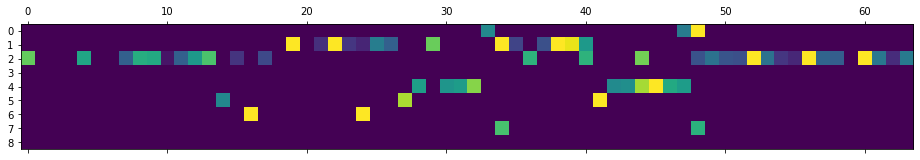

In [38]:
viz_drum_midi(filepaths[201])

32_hiphop_92_beat_4-4


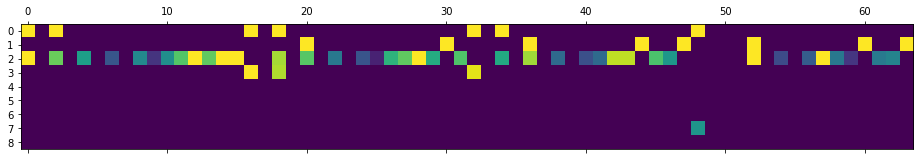

In [39]:
viz_drum_midi(filepaths[301])